In [1]:
from IPython.display import Markdown as md
from pathlib import Path
md(Path("readme.md").read_text())

This repository contains Python code and a Jupyter Notebook
running the [CONTIN program by S. Provencher](http://dx.doi.org/10.1016/0010-4655(82)90174-6)
on every DLS measurement (`*.ASC` files)
at the specified angle found in the given subfolders.


## TODO
- fix multicore (parallel) calc on Windows
- [done] plot measured and fitted correlation curve
- [done] reviewed units of *ptRange* and *fitRange* CONTIN parameters
  - *fitRange* is given in meters now
- [done] output peak statistics with uncertainties
  - by calculating the statistics of lower and upper distribution (uncertainty subtracted from and added to distribution result) and using the max. absolute value
- [done] float formatting in CONTIN input file fixed
- [done] output CONTIN error message if no output was generated

# Some Parameters (please adjust)

## Specify the measurement folder here:
(And mind the scattering angle in a cell further down!)

In [2]:
dataDir = '142 2020 MW002-02'

## CONTIN parameters

In [3]:
continConfig = dict(
    angle=90,
    ptRangeSec=(3e-7, 1e0), fitRangeM=(1e-9, 500e-9), gridpts=500,
    transformData=True, freeBaseline=True, weighResiduals=False,
    infn="contin_in.txt", outfn="contin_out.txt"
)

# Preparations

In [4]:
import jupyter_analysis_tools
from jupyter_analysis_tools.datalocations import getDataDirs, getDataFiles
jupyter_analysis_tools.utils.setPackage(globals())

Setting the current directory as package 'analyse_dls_with_contin':
  /Users/ingo/OneDrive - Bundesanstalt für Materialforschung und -prüfung (BAM)/Dokumente/2021-04 Concentration DLS/analyse_dls_with_contin.


In [5]:
dataDirs = getDataDirs(dataDir, noWorkDir=True)
dataFiles = getDataFiles(dataDirs)
dataFiles

Working in current directory '/Users/ingo/code/analyse_dls_with_contin'.
Entering '/Users/ingo/code/analyse_dls_with_contin/142 2020 MW002-02':
     contin_090 142 2020 MW002-020000_0001
     contin_090 142 2020 MW002-020000_0002
     contin_090 142 2020 MW002-020000_0003
     contin_090 142 2020 MW002-020000_averaged
     142 2020 MW002-02
4 files to be analyzed in subdirectories.


['/Users/ingo/code/analyse_dls_with_contin/142 2020 MW002-02/142 2020 MW002-020000_0001.ASC',
 '/Users/ingo/code/analyse_dls_with_contin/142 2020 MW002-02/142 2020 MW002-020000_0002.ASC',
 '/Users/ingo/code/analyse_dls_with_contin/142 2020 MW002-02/142 2020 MW002-020000_0003.ASC',
 '/Users/ingo/code/analyse_dls_with_contin/142 2020 MW002-02/142 2020 MW002-020000_averaged.ASC']

## Preparing input data for CONTIN
Creates an input file for CONTIN from an averaged McDLS DataSet object created earlier.

## Run CONTIN

In [6]:
from .contin import processFiles, getContinResults

### Using multiple CPU cores if available

In [10]:
resultDirs = processFiles(dataFiles, continConfig, nthreads=None)
resultDirs


CONTIN analysis with 12 threads took 12.7s.


[PosixPath('/Users/ingo/code/analyse_dls_with_contin/142 2020 MW002-02/contin_090 142 2020 MW002-020000_0001'),
 PosixPath('/Users/ingo/code/analyse_dls_with_contin/142 2020 MW002-02/contin_090 142 2020 MW002-020000_0002'),
 PosixPath('/Users/ingo/code/analyse_dls_with_contin/142 2020 MW002-02/contin_090 142 2020 MW002-020000_0003'),
 PosixPath('/Users/ingo/code/analyse_dls_with_contin/142 2020 MW002-02/contin_090 142 2020 MW002-020000_averaged')]

## Fetch CONTIN results

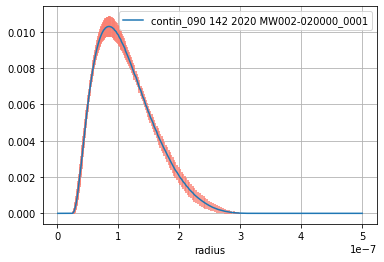

In [11]:
# show first result for testing
dn = resultDirs[0]
dfDistrib, dfFit, _ = getContinResults(dn, continConfig['outfn'], continConfig['infn'])
dfDistrib.plot('radius', 'distrib', yerr='err', ecolor='salmon', grid=True, label=dn.name);

## Investigating CONTIN results

### Some numerical helpers

In [18]:
import scipy.integrate
def integrate(xvec, yvec):
    return abs(scipy.integrate.simps(yvec, x=xvec))

def normalizeDistrib(x, y, u=None):
    # normalize the distribution to area of 1
    norm = integrate(x, y)
    #print("CONTINs norm", norm)
    y /= norm
    if u is not None:
        u /= norm
    return x, y, u

def area(xvec, yvec, showArea = True):
    """Returns a string with the area value of the given discrete curve points."""
    return " $\int${:.3g}".format(integrate(xvec, yvec)) if showArea else ""

In [19]:
def findPeakRanges(x, y, tol=1e-16):
    """Returns the location of data/peak above a base line.
    Assumes it touches the baseline before and after. For distributions.
    *tol*: Multiplied by Y to produce a threshold to distinguish noise/artifacts from peaks."""
    x = x.values if isinstance(x, pd.Series) else x
    y = y.values if isinstance(y, pd.Series) else y
    # look at all data above zero, get their array indices
    indices = np.where(y > tol*y.max())[0]
    # segmentation: look where continous groups of indices start and end
    indexGroups = np.where(np.diff(indices) > 1)[0]
    ranges = []
    istart = indices[0]
    def appendPeakRange(start, end):
        #print("appending", start, end, end-start)
        start, end = max(start-1, 0), min(end+1, len(x)-1)
        ranges.append((start, end))
    for idx in indexGroups:
        appendPeakRange(istart, indices[idx]) # add the new range to the list
        istart = indices[idx+1]               # start new range
    appendPeakRange(istart, indices[-1])
    #print("findPeakRanges", ranges)
    return ranges

In [20]:
# Testing peak ranges, find a peak in the first result
if dfDistrib is None:
    print("No distribution found in\n '{}'!".format(resultsDir))
x, y, _ = normalizeDistrib(dfDistrib.radius, dfDistrib.distrib)
peakRanges = findPeakRanges(x, y, tol=1e-6)
peakRanges

[(255, 463)]

In [21]:
class Moments(dict):
    @staticmethod
    def nthMoment(x, weights, n):
        """Calculates the nth moment of the given distribution weights."""
        center = 0
        if n > 0: # calculate the mean first
            center = np.average(x, weights=weights) if sum(weights) else 0.
            #          np.sqrt(u**2)/len(u) # center uncertainty
        if n == 1:
            return center # the mean
        var = 1.
        if n > 1:
            var = np.sum(weights*(x-center)**2) / np.sum(weights)
        if n == 2:
            return var # the variance
        return np.sum(weights*(x-center)**n) / np.sum(weights) / var**n
    @classmethod
    def fromData(cls, x, y):
        store = cls()
        mean, var, skew, kurt = [cls.nthMoment(x, y, i) for i in range(1,5)]
        store['area'] = integrate(x, y)
        store['mean'] = mean
        store['var'] = var
        store['skew'] = skew
        store['kurt'] = kurt
        return store
    @property
    def area(self):
        return self['area']
    @property
    def mean(self):
        return self['mean']
    @property
    def var(self):
        return self['var']
    @property
    def skew(self):
        return self['skew']
    @property
    def kurt(self):
        return self['kurt']
    def __str__(self):
        return "\n".join(
            ["{: <4s}: {: 9.2g}".format(k, self[k])
             for k in ("area", "mean", "var", "skew", "kurt")]
        )

In [22]:
import matplotlib.pyplot as plt
def distrParFromDistrib(mean, var, N=1.):
    # SASfit manual, 6.4. Log-Normal distribution
    median = mean**2/np.sqrt(var + mean**2)
    sigma = np.sqrt(np.log(mean**2/median**2))
    #print("momentToDistrPar", mean, var, "->", median, sigma)
    return N, sigma, median # return in the order used elsewhere for distrPar

def distrParFromPeakRanges(xvec, yvec, uvec, peakRanges, plot=None):
    distrPar = []
    moments = []
    for i, pr in enumerate(peakRanges): # for each peak
        x = xvec.values[pr[0]:pr[1]+1]
        y = yvec.values[pr[0]:pr[1]+1]
        u = uvec.values[pr[0]:pr[1]+1]
        N = integrate(x, y)
        mom = Moments.fromData(x, y)
        momLo = Moments.fromData(x, np.maximum(0, y-u))
        momHi = Moments.fromData(x, y+u)
        dptmp = distrParFromDistrib(mom.mean, mom.var, N=N)
        dptmpLo = distrParFromDistrib(momLo.mean, momLo.var, N=N)
        dptmpHi = distrParFromDistrib(momHi.mean, momHi.var, N=N)
        if plot:
            ax = plot['axes'][i+plot['startIdx']]
            plot['func'](ax, pr, (x,y,u), (xvec,yvec,uvec), (mom,momLo,momHi), (dptmp,dptmpLo,dptmpHi))
        distrPar.append(dptmp)
        moments.append(mom)
    return distrPar, moments

### Some plot helpers

In [23]:
import matplotlib.pyplot as plt
def initFigure(fig, width = 80, aspectRatio = 4./3., quiet = False):
    mmInch = 25.4
    fig.set_size_inches(width/mmInch, width/aspectRatio/mmInch)
    w, h = fig.get_size_inches()
    if not quiet:
        print("initFigure() with ({w:.1f}x{h:.1f}) mm"
              .format(w = w*mmInch, h = h*mmInch))
    return fig
    
def createFigure(width = 80, aspectRatio = 4./3., **kwargs):
    """output figure width in mm"""
    fig = plt.figure(
        #tight_layout = dict(pad = 0.05),
        **kwargs
    )
    initFigure(fig, width, aspectRatio, quiet)
    return fig

def plotVertBar(ax, xpos, ymax, color, label=None):
    ax.plot((xpos, xpos), (0, ymax), color=color, label=label)

def plotColor(idx):
    pltcol = plt.rcParams['axes.prop_cycle'].by_key()['color']
    #print(pltcol)
    pltcol = ['gray', 'lightskyblue', 'steelblue', 'red', 'salmon']
    return pltcol[idx]

def lineWidth():
    return plt.rcParams["lines.linewidth"]

### Some helpers for text formatting

In [24]:
import itertools

def fmtErr(val, std, precision = 2, width = None):
    """Formats a given value and its std. deviation to physics notation, e.g. '1.23(4)'."""
    if width is None: width = ""
    fmt = "{:"+str(width)+"."+str(precision)+"f}({:.0f})"
    #print("fmtErr val:", val, "std:", std)
    return fmt.format(val, std * 10**(precision))

def distrParToText(distrPar):
    numPars = 3
    if len(distrPar) > numPars:
        fmt = "R_{i}={:3.0f} s_{i}={:0.2f} N_{i}={:.3g}"
    else:
        fmt = "R={:3.0f} s={:0.2f} N={:.3g}"
    return [fmt.format(p[2]*1e9, p[1], p[0], i = i)
            for i, p in enumerate(grouper(distrPar, numPars))]

def distrParToFilename(distrPar, prefix=''):
    return '_'.join([prefix] + distrParToText(distrPar)).replace(' ', '_')

def distrParLatex(distrPar, *kwargs):
    return "\n".join(['$'+txt.replace(' ',r'\;')+'$' for txt in distrParToText(distrPar)])

def distrParFromFilename(fn):
    fn = fn.split('=')
    fn = [elem.lstrip('_') for elem in fn]
    fn = [(elem.split('_', maxsplit=1) if elem[0].isnumeric() else [elem]) for elem in fn]
    fn = list(itertools.chain(*fn))
    return list(itertools.chain(*[(float(grp[5]), float(grp[3]), float(grp[1])*1e-9)
                                  for grp in grouper(fn, 6)]))

# testing
distrPar = (1, 0.2, 40e-9)
print("distrPar:      ", list(grouper(distrPar, 3)))
print("distrParToText:", distrParToText(distrPar))
print("distrParLatex: ", distrParLatex(distrPar))
print("distrParToFilename:  ", distrParToFilename(distrPar))
print("distrParFromFilename:", distrParFromFilename(distrParToFilename(distrPar)))
print("distrParFromFilename:", distrParFromFilename(distrParToFilename(distrPar, "lognorm")))
print()
distrPar = (1, 0.2, 40e-9)+(1, 0.1, 10e-9)
print("distrPar:      ", list(grouper(distrPar, 3)))
print("distrParToText:", distrParToText(distrPar))
print("distrParLatex: ", distrParLatex(distrPar))
print("distrParToFilename:  ", distrParToFilename(distrPar))
print("distrParFromFilename:", distrParFromFilename(distrParToFilename(distrPar)))
print("distrParFromFilename:", distrParFromFilename(distrParToFilename(distrPar, "lognorm")))

distrPar:       [(1, 0.2, 4e-08)]
distrParToText: ['R= 40 s=0.20 N=1']
distrParLatex:  $R=\;40\;s=0.20\;N=1$
distrParToFilename:   _R=_40_s=0.20_N=1
distrParFromFilename: [1.0, 0.2, 4e-08]
distrParFromFilename: [1.0, 0.2, 4e-08]

distrPar:       [(1, 0.2, 4e-08), (1, 0.1, 1e-08)]
distrParToText: ['R_0= 40 s_0=0.20 N_0=1', 'R_1= 10 s_1=0.10 N_1=1']
distrParLatex:  $R_0=\;40\;s_0=0.20\;N_0=1$
$R_1=\;10\;s_1=0.10\;N_1=1$
distrParToFilename:   _R_0=_40_s_0=0.20_N_0=1_R_1=_10_s_1=0.10_N_1=1
distrParFromFilename: [1.0, 0.2, 4e-08, 1.0, 0.1, 1e-08]
distrParFromFilename: [1.0, 0.2, 4e-08, 1.0, 0.1, 1e-08]


## Final Plotting

In [25]:
import matplotlib.font_manager as font_manager
class GenericResult:
    color = None

    @staticmethod
    def getBarWidth(xvec):
        return np.concatenate((np.diff(xvec)[:1], np.diff(xvec)))

    @classmethod
    def plotPeakRange(cls, ax, peakRange, peakDistrib, fullDistrib, moments, distrPar):
        #print("plotPeakRange", peakRange, moments['area'])
        x, y, u = peakDistrib
        xvec, yvec, uvec = fullDistrib
        mom, momLo, momHi = moments
        dp, dpLo, dpHi = distrPar
        #ax.plot(x, y, 'o', color=cls.color)
        lbl, fmt = [], "{: <7s} {: 9.2g} ±{: 9.2g}"
        for k in "area", "median", "var", "skew", "kurt":
            if k == "median":
                lbl.append(fmt.format("median:", dp[-1], max(abs(dp[-1]-dpLo[-1]), abs(dpHi[-1]-dp[-1]))))
            else:
                lbl.append(fmt.format(k+':', mom[k], max(abs(mom[k]-momLo[k]), abs(momHi[k]-mom[k]))))
        ax.bar(x, y, width=cls.getBarWidth(x), color=cls.color, alpha=0.5, label="\n".join(lbl))
        ax.fill_between(x, np.maximum(0, y-u), y+u,
                        color='red', lw=0, alpha=0.1, label="uncertainties")
        ax.legend(prop=font_manager.FontProperties(family='monospace')); ax.grid(True);

class ContinResult(GenericResult):
    name = "CONTIN"
    xColumn = "radius"; yColumn = "distrib"; uColumn = "err"
    getResults = getContinResults
    color = plotColor(1)

class Results:
    def __init__(self, filename, rtype=None):
        self.rtype = rtype
        self.sampleDir = Path(filename)
        self.angle     = None
        self.dfDistrib, self.dfFit, self.varmap = self.rtype.getResults(self.sampleDir, self.angle)
        if self.dfDistrib is None: return
        self.x, self.y, self.u = normalizeDistrib(
            self.dfDistrib[self.rtype.xColumn], self.dfDistrib[self.rtype.yColumn], self.dfDistrib[self.rtype.uColumn])
        self.peakRanges = findPeakRanges(self.x, self.y, tol=1e-6)

    def plot(self, axes):
        if self.dfDistrib is None: return
        dp, _ = distrParFromPeakRanges(self.x, self.y, self.u, self.peakRanges,
                                       plot={'func': self.rtype.plotPeakRange,
                                             'axes': axes, 'startIdx': 2})
        # plot fitted correlation curve
        ax = axes[0]
        ax.plot(self.dfFit['tau'], self.dfFit['corrIn'],
               color="black", lw=lineWidth()*2, label="measured")
        ax.plot(self.dfFit['tau'], self.dfFit['corrFit'],
               color=self.rtype.color, label="fit")
        ax.legend()
        ax2 = ax.twinx()
        residual = self.dfFit['corrIn']-self.dfFit['corrFit']
        ax2.plot(self.dfFit['tau'], residual, 'k.', alpha=.3, label="residual")
        ax2.set_ylim([-max(abs(residual)),max(abs(residual))])
        # combine legends
        ax2handles, ax2labels = ax2.get_legend_handles_labels()
        axhandles, axlabels = ax.get_legend_handles_labels()
        ax.legend(axhandles+ax2handles, axlabels+ax2labels)
        ax.grid(); ax.set_xscale("log");
        # plot complete distribution as loaded from file
        ax = axes[1]
        lbl = ("from file, " + self.rtype.name
               + area(self.x, self.y, showArea=True)
               +"\n"+distrParLatex(dp[0]))
        ax.fill_between(self.x, self.y,
               #width=GenericResult.getBarWidth(self.x),
               color=self.rtype.color, alpha=0.5, label=lbl)
        #ax.errorbar(self.x, self.y, yerr=self.u, lw=lineWidth()*2, label=lbl)
        ax.fill_between(self.x,
                        np.maximum(0, self.y-self.u),
                        self.y+self.u,
                        color='red', lw=0, alpha=0.1, label="uncertainties")
        ax.legend(); ax.grid(); ax.set_xscale("log");

def plotResult(filename):
    filename = Path(filename)
    # CONTIN results
    cnt = Results(filename, rtype=ContinResult)
    if not hasattr(cnt, 'peakRanges'):
        return # nothing to do
    nsubplots = 2+len(cnt.peakRanges)
    fig, axes = plt.subplots(1, nsubplots, dpi=100, gridspec_kw=dict(wspace=.4))
    initFigure(fig, width=nsubplots*120, aspectRatio=nsubplots/1., quiet=True)
    fig.suptitle(filename, fontsize=10, ha='right')

    cnt.plot(axes)
    plt.savefig(filename.with_suffix('.png'))
    return cnt

<ipython-input-21-c186714fbd9c>:13: RuntimeWarning: invalid value encountered in double_scalars
  var = np.sum(weights*(x-center)**2) / np.sum(weights)
<ipython-input-21-c186714fbd9c>:16: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(weights*(x-center)**n) / np.sum(weights) / var**n


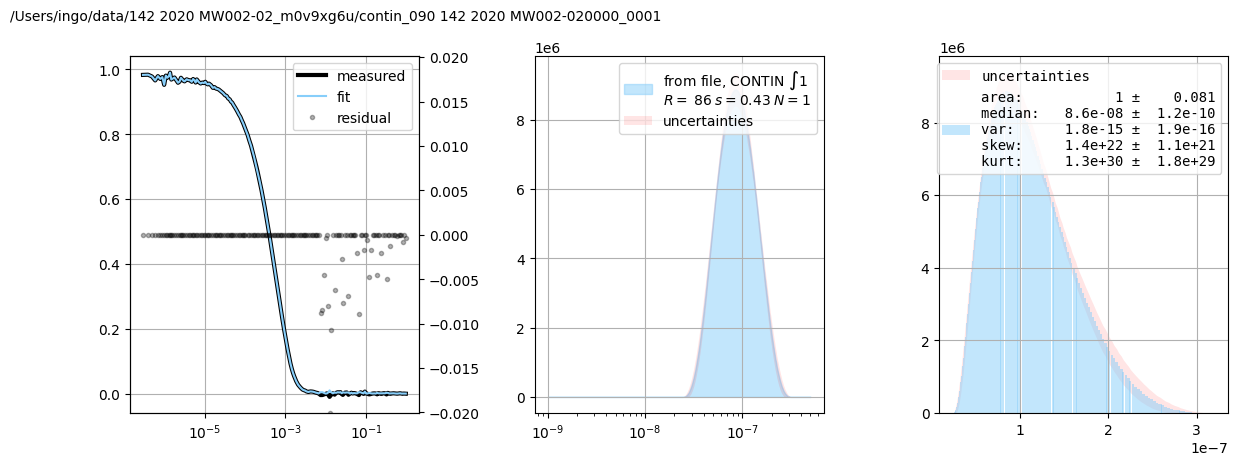

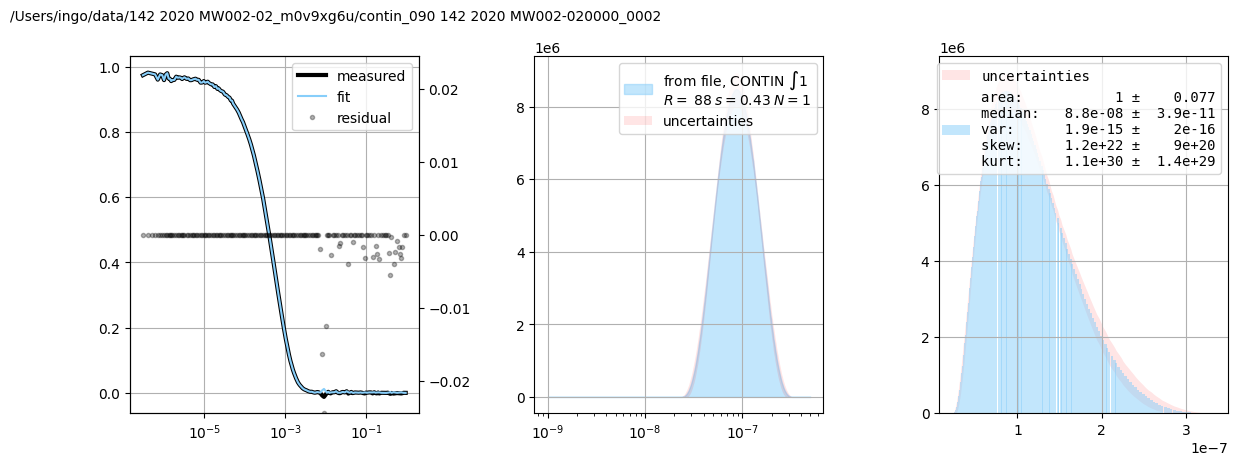

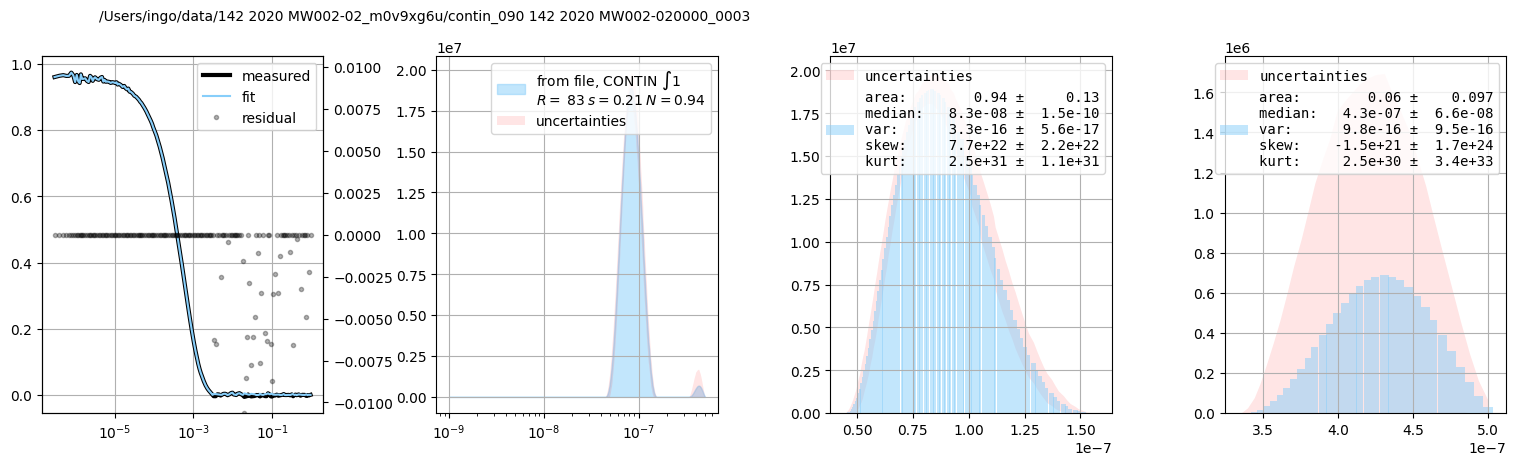

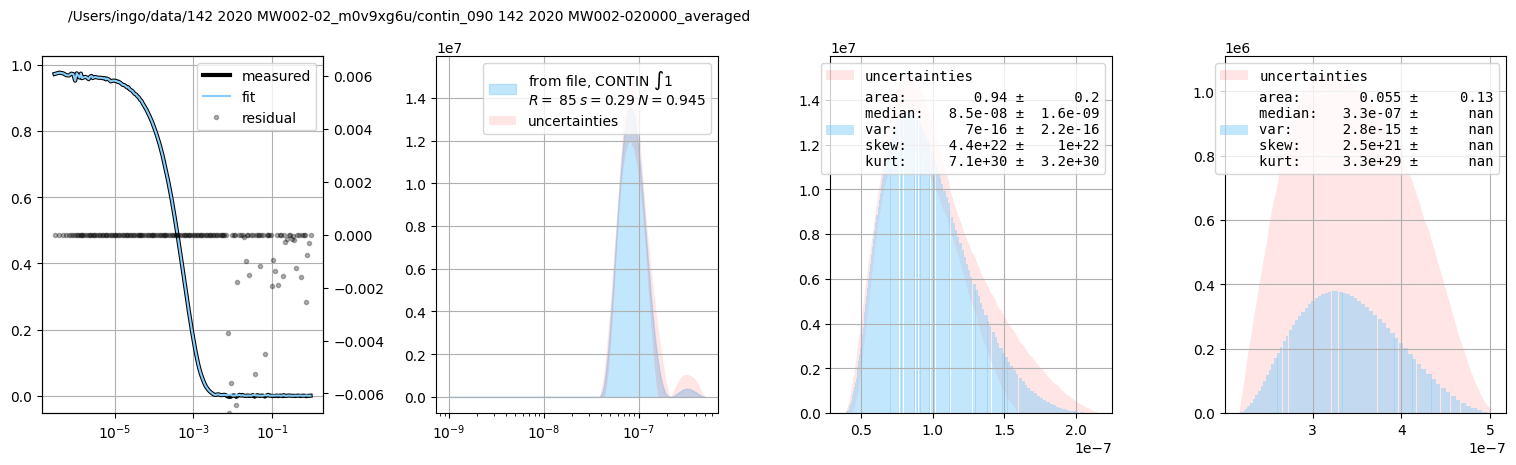

In [26]:
results = [plotResult(resultDir) for resultDir in resultDirs]

In [27]:
result = [res for res in results if "averaged" in res.sampleDir.name][0]
result.sampleDir, result.varmap

(PosixPath('/Users/ingo/data/142 2020 MW002-02_m0v9xg6u/contin_090 142 2020 MW002-020000_averaged'),
 {'temp': 292.93,
  'angle': 90.0,
  'visc': 0.0010069,
  'refrac': 1.332,
  'wavelen': 6.328e-07})

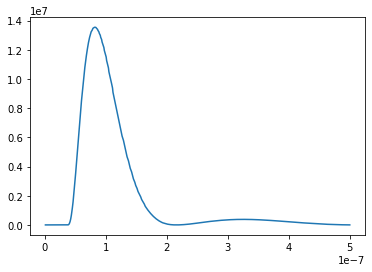

In [28]:
plt.plot(result.x, result.y)